<a href="https://colab.research.google.com/github/rjanovicci/image-recomendation-dio/blob/master/recomenda%C3%A7%C3%A3o_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!find . -name ".ipynb_checkpoints" -type d -exec rm -rf {} +


In [19]:
import os
import shutil
import random
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

In [20]:


# Caminho das pastas
SOURCE_DIR = "drive/MyDrive/dataset_objetos"  # Pasta original das imagens
DATA_DIR = "./data_objetos"  # Pasta onde ficarão train/test/val
CLASSES = os.listdir(SOURCE_DIR)

# Criar estrutura de diretórios
for split in ["train", "test", "val"]:
    for category in CLASSES:
        os.makedirs(os.path.join(DATA_DIR, split, category), exist_ok=True)

# Separar imagens em train (70%), test (20%) e val (10%)
for category in os.listdir(SOURCE_DIR):
    category_path = os.path.join(SOURCE_DIR, category)
    if os.path.isdir(category_path):
        images = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Embaralhar e dividir
        train_files, test_files = train_test_split(images, test_size=0.3, random_state=42)
        test_files, val_files = train_test_split(test_files, test_size=1/3, random_state=42)

        # Mover arquivos para as pastas corretas
        for file_list, split in [(train_files, "train"), (test_files, "test"), (val_files, "val")]:
            for file in file_list:
                src_path = os.path.join(category_path, file)
                dst_path = os.path.join(DATA_DIR, split, category, file)
                shutil.copy(src_path, dst_path)

print("Separação de dados concluída!")

Separação de dados concluída!


In [28]:
# Definição de parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apenas normalização para validação e teste
val_datagen = ImageDataGenerator(rescale=1./255)

# Criar geradores de dados
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASSES
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASSES
)

print("Geradores de dados prontos!")

Found 191 images belonging to 4 classes.
Found 29 images belonging to 4 classes.
Geradores de dados prontos!


In [29]:
# Carregar modelo base pré-treinado MobileNetV2 com input_shape correto
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar as camadas do modelo base

# Construção do modelo com camadas extras
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Ajuste para o tamanho correto
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Exibir resumo do modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:

!find ./data_objetos -name ".ipynb_checkpoints" -type d -exec rm -rf {} +
# Definir hiperparâmetros
EPOCHS = 20
learning_rate = 0.001

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Calcular pesos das classes para balanceamento
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_generator.classes), y=train_generator.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict  # Usando pesos das classes para balanceamento
)


print("Treinamento concluído!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6444 - loss: 0.8580 - val_accuracy: 0.9655 - val_loss: 0.0661
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - loss: 0.1023 - val_accuracy: 0.9655 - val_loss: 0.0394
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - accuracy: 0.9870 - loss: 0.0352 - val_accuracy: 0.9655 - val_loss: 0.0391
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9655 - val_loss: 0.0471
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.9915 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 6.5375e-04
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 5.5696e-04
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.9793 - loss: 0.0517 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 5.6940e-04 - val_accuracy: 1.0000 - val_loss: 

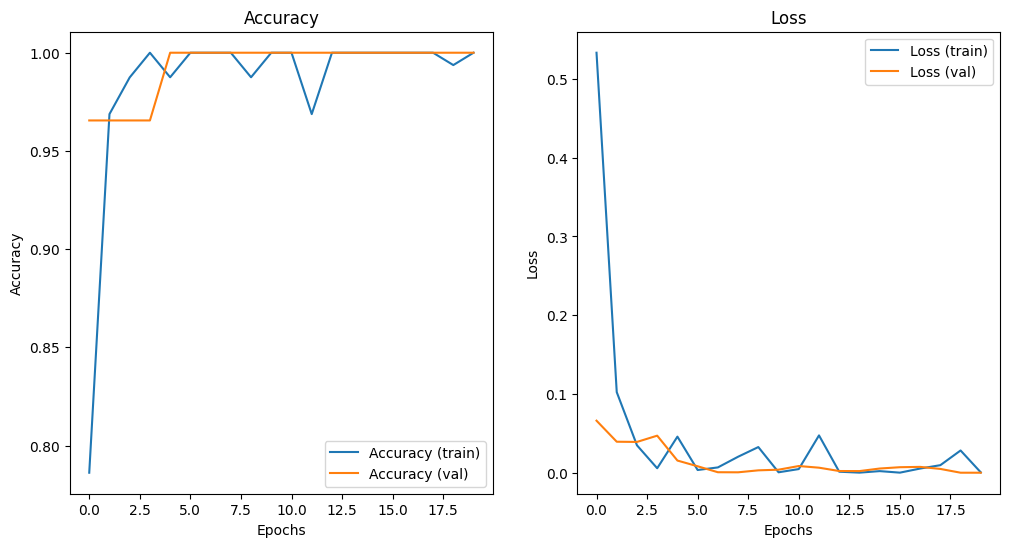

In [31]:
# Salvar o modelo treinado
model.save("fine_tuned_model.h5")

# 📊 Plotar gráficos de precisão e perda
plt.figure(figsize=(12, 6))

# Gráfico de precisão
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
# Carregar o modelo treinado
model = tf.keras.models.load_model('fine_tuned_model.h5')

# Caminho para a pasta de treino
train_dir = f"{DATA_DIR}/train"  # Substitua com o caminho correto

# Função para realizar a predição
def predict_image(img_path):
    # Carregar e preparar a imagem
    img = image.load_img(img_path, target_size=(224, 224))  # Ajuste para o tamanho de entrada
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar a dimensão do batch
    img_array /= 255.0  # Normalização

    # Fazer a previsão
    predictions = model.predict(img_array)

    # Obter as probabilidades (percentagens)
    percentages = tf.nn.softmax(predictions[0]).numpy() * 100

    # Encontrar a classe predita
    predicted_class_index = np.argmax(percentages)
    predicted_class = CLASSES[predicted_class_index]

    # Plotar 3 imagens da mesma classe
    plot_images_from_class(predicted_class)

    # Retornar o nome da classe predita e as probabilidades
    return predicted_class, dict(zip(CLASSES, percentages))

# Função para plotar 3 imagens aleatórias da mesma classe
def plot_images_from_class(class_name):
    class_dir = os.path.join(train_dir, class_name)  # Caminho da pasta da classe
    images = os.listdir(class_dir)

    # Selecionar 3 imagens aleatórias
    selected_images = random.sample(images, 3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, img_name in zip(axes, selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = image.load_img(img_path, target_size=(224, 224))
        ax.imshow(img)
        ax.axis('off')  # Desativa o eixo para exibição limpa
        ax.set_title("")
    plt.show()

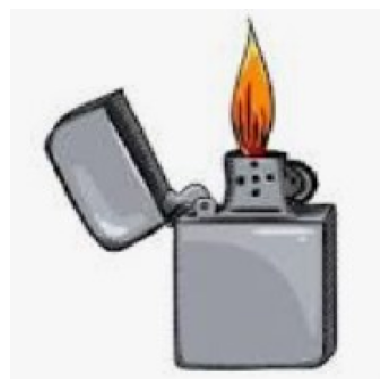

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


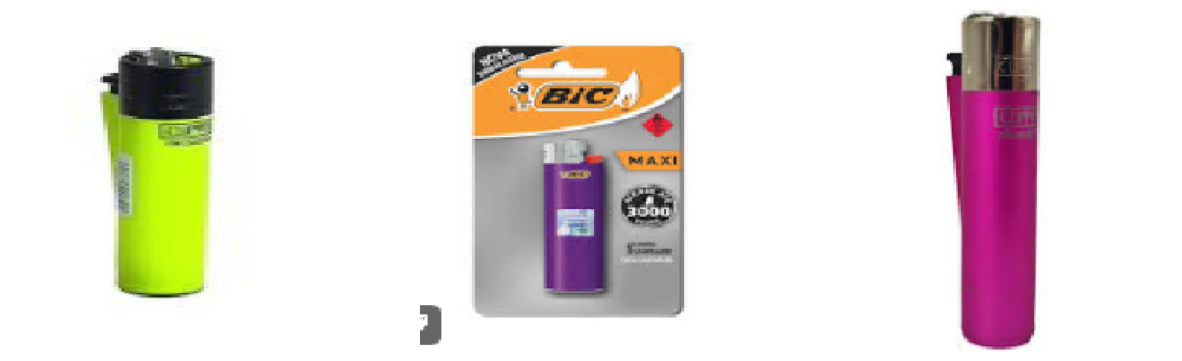

{'003mug': 18.8519, '001glasses': 24.745237, '004rbcube': 18.666258, '002lighter': 37.736603}


In [40]:
# Testar com uma imagem
img_path = "3.jpg"  # Substitua pelo caminho da imagem

# Mostrar a imagem junto com a predição
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title("")
plt.axis('off')  # Desativa o eixo para exibição limpa
plt.show()

predicted_class, result = predict_image(img_path)

print(result)